# Test functions

## Prototyping

## Collaborative Filtering

In [1]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.

### Generate synthetic data

In [2]:
def remove_missing_data(X, is_data):
    """
    Turn missing data into NaN.
    
    Parameters
    ----------
    X : array
        The data array that must be moderated.
    is_data : array
        Array specifying if the value in `X` in the 
        respective position was observed (1) or not (0).
    
    Returns
    -------
    masked : array
        Same as `X` but with np.NaN where `is_data == 0`.
    """
    
    assert X.shape == is_data.shape, '`X` and `is_data` must have the same shape.'
    assert set(np.unique(is_data)) - {0, 1} == set(), '`is_data` can only contain integers 0 and 1.'
    
    masked = np.where(is_data == 1, X, np.NaN)
    return masked

In [10]:
def regularization_cost(alpha, vec_users, vec_prods):
    """
    Return the regularization cost function.
    
    Parameters
    ----------
    alpha : float
        Regularization parameter. Larger `alpha` means 
        more regularization (`alpha > 0`).
    vec_users : array, shape (n_latent, n_users)
        Vectors of dimension `n_latent` that represent
        `n_users` users.
    vec_prods : array, shape (n_latent, n_prods)
        Vectors of dimension `n_latent` that represent
        `n_prods` products.    

    Returns
    -------
    reg : float
        Regularization term.
    """
    #assert alpha > 0, '`alpha` must be non-negative.'
    reg = alpha * (np.sum(vec_users**2) + np.sum(vec_prods**2))
    return reg

def data_cost_function(centered_X, vec_users, vec_prods):
    """
    Fit cost function: sum of squared errors.
    
    Parameters
    ----------
    centered_X : array, shape (n_prods, n_users)
        Ratings of the users (columns) on the products (rows).
        The mean rating (over the users) for each product
        must have been subtracted already. Missing data should 
        be NaN.
    vec_users : array, shape (n_latent, n_users)
        Vectors of dimension `n_latent` that represent
        `n_users` users.
    vec_prods : array, shape (n_latent, n_prods)
        Vectors of dimension `n_latent` that represent
        `n_prods` products.    

    Returns
    -------
    sqerr : float
        Cost function regarding the fit to the data.
    """
    
    X_fit = vec_prods.T.dot(vec_users)
    sqerr = np.nansum((centered_X - X_fit)**2)
    
    return sqerr

def cost_function(centered_X, vec_users, vec_prods, alpha):
    """
    Fit cost function: sum of squared errors + regularization
    term.
    
    Parameters
    ----------
    centered_X : array, shape (n_prods, n_users)
        Ratings of the users (columns) on the products (rows).
        The mean rating (over the users) for each product
        must have been subtracted already.
    vec_users : array, shape (n_latent, n_users)
        Vectors of dimension `n_latent` that represent
        `n_users` users.
    vec_prods : array, shape (n_latent, n_prods)
        Vectors of dimension `n_latent` that represent
        `n_prods` products.    
    alpha : float
        Regularization parameter. Larger `alpha` means 
        more regularization (`alpha > 0`).
 
    Returns
    -------
    cost : float
        Cost function value.
    """
    
    cost = data_cost_function(centered_X, vec_users, vec_prods) + regularization_cost(alpha, vec_users, vec_prods)
    return cost


def min_wrapper(vecs, n_users, n_prods, n_latent, centered_X, alpha):
    
    # Split user and product vectors:
    nd_users   = n_users * n_latent
    flat_users = vecs[:nd_users] 
    flat_prods = vecs[nd_users:]
    
    #vec_users = flat_users.vec

In [4]:
seed = 357
n_users = 20
n_prods = 10 
n_latent  = 4
err_sig   = 0.2
miss_frac = 0.5

In [5]:
# Instantiate random number generator: 
rng = np.random.default_rng(seed)

# Generate data mask (where we have data):
X_shape = (n_prods, n_users)
exist_data = (rng.random(X_shape) > miss_frac).astype(int)
exist_data[:,-1] = 0 # Last user is always missing.

# Generate data:
vec_users = rng.normal(size=(n_latent, n_users))
vec_prods = rng.normal(size=(n_latent, n_prods))
X_true    = vec_prods.T.dot(vec_users)
# Add noise:
noise     = rng.normal(scale=err_sig, size=X_shape)
X         = X_true + noise
# Remove missing data:
X = remove_missing_data(X, exist_data)

In [6]:
is_data = exist_data

masked_X = remove_missing_data(X, is_data)
mean_X = np.nanmean(masked_X, axis=1)

In [7]:
centered_X = X - np.transpose([mean_X])

In [9]:
cost_function(vecs, centered_X, vec_users, vec_prods, alpha)

112.09713145059959

### Retrieving ZIP files

#### All here

In [1]:
import requests
import zipfile
import io

def set_slash(directory):
    
    assert type(directory) == str, '`directory` should be a str.'
    
    if directory[-1] != '/':
        return directory + '/'
    else:
        return directory

    
def concat_path(path_parts_list):
    """
    Joins a list of parts of path (sub-directories and file) into a full path.
    """
    
    assert type(path_parts_list) == list and type(path_parts_list[0] == str), \
    '`path_parts_list` should be a list of str.'
    
    full_path = ''.join([set_slash(path_part) for path_part in path_parts_list])
    return full_path[:-1]


def include_zip_dir(root_dir, url):
    """
    Create a new directory path (str) by adding the name of the zip file 
    stored in `url` (str) to `root_dir`, e.g.:
        `../dados/` + `http://test.org/file.zip` = `../dados/file` 
    """
    return concat_path([root_dir, url.split('/')[-1][:-4]])

In [12]:
def retrieve_zipped_files(url, save_dir, verbose=True, timeout=10800, keep_zip_dir=True):
    """
    Downloads a ZIP file and unzip it.
    
    Parameters
    ----------
    url : str
        The URL address of the file to download.        
    save_dir : str
        The path to the folder where to save the unzipped files. New 
        folders are created as needed.      
    verbose : bool (default True)
        Whether or not to print status messages along the process.    
    timeout : int (detault 10800)
        Number of seconds to wait for download before giving up. Default 
        is 3 hours.    
    keep_zip_dir : bool (default True)
        Wheter or not to unzip the content of the zip file into a folder of same name
        (inside `save_dir` folder).
        
    Returns
    -------
    Nothing
    """
    
    assert type(timeout) == int and timeout > 0, '`timeout` should be a int > 0.'
    assert type(url) == str, '`url` should be a str.'
    assert type(save_dir) == str, '`save_dir` should be a str.'
    assert url[-4:].lower() == '.zip', 'Expecting ZIP file.'

    if verbose:
        print('Downloading file...')
    session = requests.session()
    session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
    response = session.get(url, timeout=timeout)

    if response.status_code != 200:
        raise Exception('HTTP request failed with code ' + str(response.status_code))
    
    if verbose:
        print('Unzipping file...')
    z = zipfile.ZipFile(io.BytesIO(response.content))

    if keep_zip_dir == True:
        save_dir = include_zip_dir(save_dir, url)
    z.extractall(save_dir)
    if verbose:
        print('Files unzipped to ' + save_dir)

        
def sync_remote_zipped_files(url, save_dir, verbose=True, timeout=10800, keep_zip_dir=True, force_download=False):
    """
    Downloads a ZIP file and unzip it if requested or if not locally present.
    
    Parameters
    ----------
    url : str
        The URL address of the file to download.        
    save_dir : str
        The path to the folder where to save the unzipped files. New 
        folders are created as needed.      
    verbose : bool (default True)
        Whether or not to print status messages along the process.    
    timeout : int (detault 10800)
        Number of seconds to wait for download before giving up. Default 
        is 3 hours.    
    keep_zip_dir : bool (default True)
        Wheter or not to unzip the content of the zip file into a folder of same name
        (inside `save_dir` folder).
    force_download : bool
        If True, download the file again and overwrite it. If False, do not
        download the file if it is already present.
        
    Returns
    -------
    Nothing
    """
    
    # Get local file pattern:
    zip_filename = url.split('/')[-1]
    stem = filestem(zip_filename)
    file_pattern = os.path.join(save_dir, stem)
    # Get matching files:
    matching_files = glob(file_pattern) + glob(file_pattern + '.*')

    # Warning (more than one match, I don't know what to do):
    if len(matching_files) > 1 and verbose is True:
        # More than one match, I don't know what to do:
        print('!! Found more than one matching file or folder.')
        print(matching_files)
        
    # Found local file:
    if len(matching_files) > 0:
        # Download file:
        if force_download is True:
            print('Found a local file, will overwrite.')
            retrieve_zipped_files(url, save_dir, verbose=verbose, timeout=timeout, keep_zip_dir=keep_zip_dir)
        else:
            print('Found a local file, skip download.')
    else:
        print('No local file found.')
        retrieve_zipped_files(url, save_dir, verbose=verbose, timeout=timeout, keep_zip_dir=keep_zip_dir)

In [13]:
import os
from glob import glob

In [14]:
def filestem(filename):
    """
    Returns the stem (str) of the `filename` (str), i.e. everything 
    up to the last dot that usually marks the file extension
    """
    stem = '.'.join(filename.split('.')[:-1])
    return stem

In [17]:
#u = 'https://nuvem.ceweb.br/s/NspgTDAow7d7mNQ/download/consulta_cand_2022.zip'
u = 'https://nuvem.ceweb.br/s/9GwmKE2N8FfEDcf/download/consulta_cand_2022_BRASIL.zip'
sync_remote_zipped_files(u, '/home/hxavier/temp', keep_zip_dir=False, force_download=True)

No local file found.
Unzipping file...
Files unzipped to /home/hxavier/temp


#### In module

In [1]:
import data_retriever as xz

In [5]:
#xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/NspgTDAow7d7mNQ/download/consulta_cand_2022.zip', '/home/hxavier/temp/', keep_zip_dir=False)

Found a local file, skip download.


In [6]:
#xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/9GwmKE2N8FfEDcf/download/consulta_cand_2022_BRASIL.zip', '/home/hxavier/temp/', keep_zip_dir=False)

Found a local file, skip download.


### Causal

In [21]:
import pygraphviz as gv
from PIL import Image
import io
from IPython.display import display

In [23]:
def format_node(G, node_name, node_type, node_format={'target':'filled', 'hidden':'dashed'}):
    """
    Format in place a node in a graph according to the variable 
    type: hidden variable (unobserved) or target.
    
    Parameters
    ----------
    G : AGraph
        Graph created with pygraphviz containing the node
        to be formatted.
    node_name : str
        Name of the node to be formatted. This is the string
        drawn inside the ellipse.
    node_type : str
        Either 'target' or 'hidden'.
    node_format : dict
        From the node type (str) to the style (str) to be used
        for that node.
    """
    G.get_node(node_name).attr['style'] = node_format[node_type]

    
def plot_diagram(causal_links, special_nodes=None, rankdir='LR'):
    """
    Given a list of directed edges (represented
    by tuples of two elements), draws a graph.
    """
    
    # Build graph:
    G = gv.AGraph(directed=True, rankdir=rankdir)
    G.add_edges_from(causal_links)
    
    # Formatting nodes, is requested:
    if special_nodes is not None:
        
        # Security checks:
        node_types = {'hidden', 'target'}
        assert type(special_nodes) is dict, '`special_nodes` should be dict, but are {}.'.format(type(special_nodes))
        unknown_keys = set(special_nodes.keys()) - node_types
        assert unknown_keys == set(), 'Found unknown node types {}.'.format(unknown_keys)
        
        # Loop over special node types:
        for node_type in special_nodes.keys():
        
            # Standardize `node_names` to list:
            node_names = special_nodes[node_type]
            if type(node_names) in (str, int):
                node_names = [node_names]
                
            # Format nodes of the given type:
            for node_name in node_names:
                format_node(G, node_name, node_type)
    
    # Draw graph:
    G.layout(prog='dot')
    img_bytes = G.draw(format='png')
    image = Image.open(io.BytesIO(img_bytes))
    display(image)

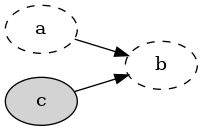

In [ ]:
plot_diagram([('a', 'b'), ('c', 'b')], {'hidden': ['a', 'b'], 'target':'c'})

### Google drive

In [1]:
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
   
# For using listdir()
import os

In [2]:
   
  
# Below code does the authentication
# part of the code
gauth = GoogleAuth()
  

In [3]:
# Creates local webserver and auto
# handles authentication.
gauth.LocalWebserverAuth()       

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=762837668684-0lmff8drh7rf2b253nsp65mraef6hp7a.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [4]:
drive = GoogleDrive(gauth)

In [ ]:
 
# replace the value of this variable
# with the absolute path of the directory
path = r""   
   
# iterating thought all the files/folder
# of the desired directory
for x in os.listdir(path):
   
    f = drive.CreateFile({'title': x})
    f.SetContentFile(os.path.join(path, x))
    f.Upload()
  
    # Due to a known bug in pydrive if we 
    # don't empty the variable used to
    # upload the files to Google Drive the
    # file stays open in memory and causes a
    # memory leak, therefore preventing its 
    # deletion
    f = None

### Previous

In [1]:
import numpy as np
import pandas as pd


def test_assert(assertion, message='Assertion failed', verbose=True):
    """
    Test if an assertion is True, printing
    a message if it is not.
    
    Parameters
    ----------
    assertion : bool
        The test made, which can be True
        (the expected result) or False.
    message : str
        Message to print out if `assertion`
        is False.
    verbose : bool
        Whether to print the `message` or 
        not.
    
    Returns
    -------
    result : bool
        Whether the assertion is True or
        False.
    """
    if not assertion:
        if verbose is True:
            print(message)
        return False
    
    return True


def direct_comparison(result, output, verbose=False, ith_test=''):
    """
    Check if `result` is equal to `output` directly:
    `result == output`. If `verbose` is True, print 
    this function's name.
    """
    if verbose is True:
        print('direct_comparison')

    test_assert(result == output, '{}: Function output "{}" does not match expected `output` "{}".'.format(ith_test, result, output))

    
def float_comparison(result, output, numerical=False, verbose=False, ith_test=''):
    """
    Check if `result` is equal to `output` directly:
    `result == output`. If `verbose` is True, print 
    this function's name.
    """
    if verbose is True:
        print('float_comparison')
    
    # Exact match:
    if not numerical: 
        test_assert(result == output, '{}: Function output "{}" does not match expected `output` "{}".'.format(ith_test, result, output))
    
    # Numerical comparison:
    else:
        test_assert(np.isclose(result, output), '{}: Function output "{}" is not close enough to expected `output` "{}".'.format(ith_test, result, output))


def listlike_comparison(result, output, numerical=False, verbose=False, ith_test=''):
    """
    Check if type and elements of `result` and 
    `output` are the same. 
    
    If `numerical` is True, use `np.isclose()` 
    to avoid round-off errors.
    
    If `verbose` is True, print this function's name.
    """
    if verbose is True:
        print('listlike_comparison')

    # Exact comparison:
    if not numerical:
        test_assert(result == output, '{}: Function output "{}" does not match expected `output` "{}".'.format(ith_test, result, output))

    # Numerical comparison:
    else:
        same_type = test_assert(type(result) == type(output), '{}: Function output type "{}" does not match `output` type "{}".'.format(ith_test, type(result), type(output)))
        if same_type is True:
            test_assert(np.isclose(np.array(result), np.array(output)).all(), '{}: Function output "{}" is not close enough to expected `output` "{}".'.format(ith_test, result, output))


def elwise_comparison(result, output, numerical=False, verbose=False, ith_test=''):
    """
    Check if type and elements of `result` and 
    `output` are the same, for array-like input. 
    
    If `numerical` is True, use `np.isclose()` 
    to avoid round-off errors.
    
    If `verbose` is True, print this function's name.
    """
    if verbose is True:
        print('elwise_comparison')
    
    # Check type:
    same_type = test_assert(type(result) == type(output), '{}: Function output type "{}" does not match `output` type "{}".'.format(ith_test, type(result), type(output)))
    
    # Check len:
    if same_type is True:
        same_len = test_assert(len(result) == len(output), '{}: Function output length "{}" does not match `output` length "{}".'.format(ith_test, len(result), len(output)))
        
        # Check index if any:
        if same_len is True:
            same_idx = True
            if type(output) in (pd.core.series.Series,):
                same_idx = test_assert((result.index == output.index).all(), '{}: Function output index "{}" do not match expected `output` index "{}".'.format(ith_test, result.index, output.index))
            
            # Check dtype, if any:
            if same_idx:
                same_dtype = True
                if type(output) in (pd.core.series.Series,):
                    same_dtype = test_assert(result.dtype == output.dtype, '{}: Function output dtype "{}" do not match expected `output` dtype "{}".'.format(ith_test, result.dtype, output.dtype))

                # Check values:
                if same_dtype:
                    if not numerical:
                        test_assert((result == output).all(), '{}: Function output "{}" does not match expected `output` "{}".'.format(ith_test, result, output))
                    else:
                        test_assert(np.isclose(result, output).all(), '{}: Function output "{}" is not close enough to expected `output` "{}".'.format(ith_test, result, output))
    

def dataframe_comparison(result, output, verbose=False, ith_test=''):
    """
    Check if type, columns, index and values of 
    `result` and `output` are the same, expecting
    two DataFrames as input. If `verbose` is True, 
    print this function's name.
    """
    
    if verbose is True:
        print('dataframe_comparison')
    
    # Check type:
    same_type = test_assert(type(result) == type(output), '{}: Function output type "{}" does not match `output` type "{}".'.format(ith_test, type(result), type(output)))
    
    # Check # cols:
    if same_type is True:
        same_ncols = test_assert(len(result.columns) == len(output.columns), 
                                 '{}: Function output number of columns "{}" does not match expected `output` number of columns "{}".'.format(ith_test, len(result.columns), len(output.columns)))
        # Check columns:
        if same_ncols is True:
            same_cols = test_assert((result.columns == output.columns).all(), '{}: Function output columns "{}" do not match expected `output` columns "{}".'.format(ith_test, result.columns, output.columns))
        
            # Check # rows:
            if same_cols is True:
                same_nrows = test_assert(len(result.index) == len(output.index), '{}: Function output number of rows "{}" does not match expected `output` number of rows "{}".'.format(ith_test, len(result.index), len(output.index)))
            
                # Check index:
                if same_nrows is True:
                    same_idx = test_assert((result.index == output.index).all(), '{}: Function output index "{}" do not match expected `output` index "{}".'.format(ith_test, result.index, output.index))

                    # Check values:
                    if same_idx is True:
                        test_assert(((result == output) == ~(result.isnull() & output.isnull())).all().all(), 
                                    '{}: Function output "{}" does not match expected `output` "{}".'.format(ith_test, result, output)) 

                        
def test_function(f, args=tuple(), output=None, kwargs=dict(), numerical=False, ith_test='', verbose=False):
    """
    Check if a function's output is the expected
    one.
    
    Parameters
    ----------
    f : callable
        Function to test.
    args : tuple
        Positional arguments for `f`.
    kwargs : dict
        Keyword arguments for `f`.
    output : anything
        Expected output of `f` given the inputs 
        above.
    numerical : bool
        If `numerical` is True, use `np.isclose()` 
        when possible to avoid round-off errors.
    ith_test : int or None
        The number of the test, to be printed out in
        case of failure.
    verbose : bool
        If True, print extra information about 
        the evaluation process besides the 
        failed tests.
    """
    
    # Get function's output:
    result = f(*args, **kwargs)
    
    # Direct comparison:
    if type(output) in (str, int, dict, bool):
        direct_comparison(result, output, verbose, ith_test)
    
    # Float comparison
    elif type(output) in (float,):
        float_comparison(result, output, numerical, verbose, ith_test)
    
    # Element-wise comparison:
    elif type(output) in (tuple, list, set):
        listlike_comparison(result, output, numerical, verbose, ith_test)

    # Built-in element-wise comparison:
    elif type(output) in (np.ndarray, pd.core.series.Series):
        elwise_comparison(result, output, numerical, verbose, ith_test)
    
    # DataFrame comparison:
    elif type(output) in (pd.core.frame.DataFrame,):
        dataframe_comparison(result, output, verbose, ith_test)
        
    else:
        print('Unknown output type.')

        
def multi_test_function(f, parameters, outputs, numerical=False, verbose=False):
    """
    Run multiple tests on function `f` by using
    the provided input parameters and comparing
    the function's output with an expected 
    output.
    
    Parameters
    ----------
    f : callable
        Function to be tested.
    parameters : list of tuples and dicts
        Each tuple or dict in the list are 
        the positional or keyword `f` 
        parameters, respectively, to be used as 
        input for a test.
    outputs : list or non-iterable
        The expected outputs from `f` given 
        the inputs `parameters`. It can be one 
        output for each input or a single 
        common output for all inputs.
    numerical : bool or list of bool
        For each test, specifies if the 
        comparison between each output and 
        expected output is to be made 
        tolerating float round-off errors or
        not.
    verbose : bool or list of bool
        Whether to print extra messages for 
        each test or not.
    """
    
    # Security checks:
    assert type(parameters) is list, '`parameters` must be a list of inputs.'
    
    # Standardize input:
    if type(outputs) is not list:
        outputs = len(parameters) * [outputs]
    if type(numerical) is bool:
        numerical = len(outputs) * [numerical]
    if type(verbose) is bool:
        verbose = len(outputs) * [verbose]
    
    # Security checks:
    assert len(parameters) == len(outputs), '`parameters` have len {} while `outputs` have len {}. They should be the same.'.format(len(parameters), len(outputs))
    assert len(parameters) == len(numerical), '`parameters` have len {} while `numerical` have len {}. They should be the same.'.format(len(parameters), len(numerical))
    assert len(parameters) == len(verbose), '`parameters` have len {} while `verbose` have len {}. They should be the same.'.format(len(parameters), len(verbose))
     
    # Loop over test cases:
    tests = range(1, len(outputs) + 1)
    for i, params, output, num, verb in zip(tests, parameters, outputs, numerical, verbose):
        
        # Positional input:
        if type(params) in (tuple,):
            test_function(f, params, output, numerical=num, verbose=verb, ith_test=i)
        
        # Keyword input:
        elif type(params) in (dict,):
            test_function(f, kwargs=params, output=output, numerical=num, verbose=verb, ith_test=i)
        
        else:
            raise Exception('Unknown `parameters` element type "{}".'.format(type()))
    

## Testing

In [2]:
def z(args):
    return args

In [14]:
A = pd.DataFrame({'a': [1,2,3], 'b':['a', 'b', 'c'], 'c':[0.1, 0.01, 0.001]}, index=[10,20,30])
B = {'a': [1,2,3], 'b':['a', 'b', 'c'], 'c':[0.1, 0.01, 0.001]}
C = pd.DataFrame({'a': [1,2,3], 'b':['a', 'b', 'c'], 'd':[0.1, 0.01, 0.001], 'e':[1,2,3]}, index=[10,20,30])
D = pd.DataFrame({'a': [1,2,3], 'b':['a', 'b', 'c'], 'e':[0.1, 0.01, 0.001]}, index=[10,20,30])
E = pd.DataFrame({'a': [1,2], 'b':['a', 'b'], 'c':[0.1, 0.01]}, index=[10,20])
F = pd.DataFrame({'a': [1,2,3], 'b':['a', 'b', 'c'], 'c':[0.1, 0.01, 0.001]}, index=[1,2,3])
G = pd.DataFrame({'a': [1,2,3], 'b':['a', 'b', 'd'], 'c':[0.1, 0.01, 0.001]}, index=[10,20,30])
a = {'a': 3, 'B': 1.0 + 1e-12, 2:4.5}
b = {'a': 3, 'B': 1, 2:4.5}
x = np.array([1,2,3,4,5])
y = np.array([1,2,3,4,5.0 + 1e-6])
s = pd.Series([1,2,3,4,5], dtype=float)
r = pd.Series([1,2,3,4,5], index=[10,20,30,40,50])
t = pd.Series([1,2,3,4,5.004])
u = pd.Series([1,2,3,4,5], dtype=int)
null_df  = pd.DataFrame({'A': [1,2,3], 'B  ': ['   a', None, 'c'], '   C or D':[2, None, None], 'X':[None] * 3}, index=[' aa ', ' bb ', ' cc '])
wrong_df = pd.DataFrame({'A': [1,2,3], 'B  ': ['   a', None, 'c'], '   C or D':[1, None, None], 'X':[None] * 3}, index=[' aa ', ' bb ', ' cc '])

In [15]:
inputs  = [(A,), (B,), (C,), (D,), (E,), (F,), (G,), (10,), (11,), ('hello',), ('world',), (10.67573,), (10.12345,), 
           ([1,2,3,4,5],), ([1,2,3],), (['a', 'abc'],), (['a', 'abc'],), (x,), (y,), (x[1:],), (a,), (b,), (True,), (False,),
           (s,), (s.values,), (s.iloc[1:],), (r,), (t,), (u,), (null_df,), (wrong_df,)]
outputs = [A, A, A, A, A, A, A, 10, 10, 'hello', 'hello', 10.67573, 10.12346, 
           [1,2,3,4], [1,2,2], ['a', 'abc'], ['a', 'abC'], x, x, x, a, a, True, True,
           s, s, s, s, s, s, null_df, null_df]
multi_test_function(z, inputs, outputs, verbose=False)

2: Function output type "<class 'dict'>" does not match `output` type "<class 'pandas.core.frame.DataFrame'>".
3: Function output number of columns "4" does not match expected `output` number of columns "3".
4: Function output columns "Index(['a', 'b', 'e'], dtype='object')" do not match expected `output` columns "Index(['a', 'b', 'c'], dtype='object')".
5: Function output number of rows "2" does not match expected `output` number of rows "3".
6: Function output index "Int64Index([1, 2, 3], dtype='int64')" do not match expected `output` index "Int64Index([10, 20, 30], dtype='int64')".
7: Function output "    a  b      c
10  1  a  0.100
20  2  b  0.010
30  3  d  0.001" does not match expected `output` "    a  b      c
10  1  a  0.100
20  2  b  0.010
30  3  c  0.001".
9: Function output "11" does not match expected `output` "10".
11: Function output "world" does not match expected `output` "hello".
13: Function output "10.12345" does not match expected `output` "10.12346".
14: Function o